## In this notebook, we will try to predict the category of tumors based on images
## We will use a Densenet Model for this task

In [2]:
import numpy as np
import scipy.misc
from matplotlib.pyplot import imshow
import pydot
from IPython.display import SVG

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

import numpy as np
import os
import random
import cv2
import math
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss

2024-06-03 09:35:19.992763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 09:35:19.992893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 09:35:20.098013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_data(base_path):
    def process_images(directory):
        data = []
        labels = []
        # List all sub-directories in the base directory
        categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        
        for category in categories:
            path = os.path.join(directory, category)
            images = os.listdir(path)
            for img in images:
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))  # Resize image to match ResNet-50 input
                image = img_to_array(image)
                data.append(image)
                labels.append(category)
        
        # Convert lists to numpy arrays
        data = np.array(data, dtype="float32") / 255.0
        labels = np.array(labels)
        
        # Shuffle data and labels together
        data, labels = shuffle(data, labels, random_state=42)
        
        return data, labels

    train_dir = os.path.join(base_path, 'Training')
    test_dir = os.path.join(base_path, 'Testing')

    # Load training and test data
    xtrain, ytrain = process_images(train_dir)
    xtest, ytest = process_images(test_dir)

    # Encode labels to one-hot
    lb = LabelBinarizer()
    ytrain = lb.fit_transform(ytrain)
    ytest = lb.transform(ytest)  # Use the same fit to transform test labels

    return xtrain, ytrain, xtest, ytest

## Load data

In [4]:
# Load data
xtrain, ytrain, xtest, ytest = load_data('/kaggle/input/brain-tumor-classification-mri')

In [5]:
xtrain.shape,ytrain.shape

((2870, 224, 224, 3), (2870, 4))

In [6]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.



def identity_block(X, f, filters, stage, block):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [7]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [8]:
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(64, 64, 3), classes=3):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # convolutional_block is a function defined above. Convolutional_block have 3 layers.
    #filters=[64, 64, 256] first 64 is for 1st layer and 2nd 64 is for 2nd layer and 256 is for 3rd layer of convultional block   
    # below are the conv layers from convolutional_block function
    #X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    #X = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
   
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    #X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    #X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
  
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    #X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    #X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    #X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)


    ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


## Model

In [9]:
# Séparer les données d'entraînement en données d'entraînement et de validation
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(xtrain, ytrain, batch_size=batch_size)

In [10]:
model = ResNet50(input_shape = (224, 224, 3), classes = 4)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 112, 112,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 55, 55,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 55, 55,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 55, 55,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 55, 55,    │     36,928 │ activation_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 55, 55,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 55, 55,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 55, 55,    │     16,640 │ activation_2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 55, 55,    │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 55, 55,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 55, 55,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ bn2a_branch2c[0]

 Total params: 23,661,444 (90.26 MB)

 Trainable params: 23,608,324 (90.06 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
#Model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
filepath = "resnet.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# List of callbacks
callbacks_list = [checkpoint]

# Fit the model
model.fit(train_generator, epochs=50, verbose=1, callbacks=callbacks_list, validation_data=(xval, yval))

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.3111 - loss: 5.6820
Epoch 1: val_accuracy improved from -inf to 0.28696, saving model to resnet.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3119 - loss: 5.6456 - val_accuracy: 0.2870 - val_loss: 1.3887
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4448 - loss: 1.7308
Epoch 2: val_accuracy did not improve from 0.28696
58/58 ━━━━━━━━━━━━━━━━━━━━ 85s 379ms/step - accuracy: 0.4447 - loss: 1.7338 - val_accuracy: 0.2565 - val_loss: 1.7491
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4622 - loss: 1.5920
Epoch 3: val_accuracy did not improve from 0.28696
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step - accuracy: 0.4628 - loss: 1.5878 - val_accuracy: 0.2609 - val_loss: 3.9172
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5798 - loss: 1.0470
Epoch 4: val_accuracy did not improve from 0.28696
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 379ms/step - accuracy: 0.5800 - loss: 

In [13]:
# Charger les meilleurs poids après l'entraînement
model.load_weights('/kaggle/working/resnet.keras')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/resnet.keras'

In [22]:
preds = model.predict(xtest, batch_size=batch_size, verbose=1)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Calculer et afficher la matrice de confusion
ypred_classes = np.argmax(preds, axis=1)
ytest_classes = np.argmax(ytest, axis=1)
cm = confusion_matrix(ytest_classes, ypred_classes)
cm

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step


array([[20, 37, 35,  8],
       [ 0, 93, 16,  6],
       [ 1,  9, 94,  1],
       [ 3,  0,  6, 65]])

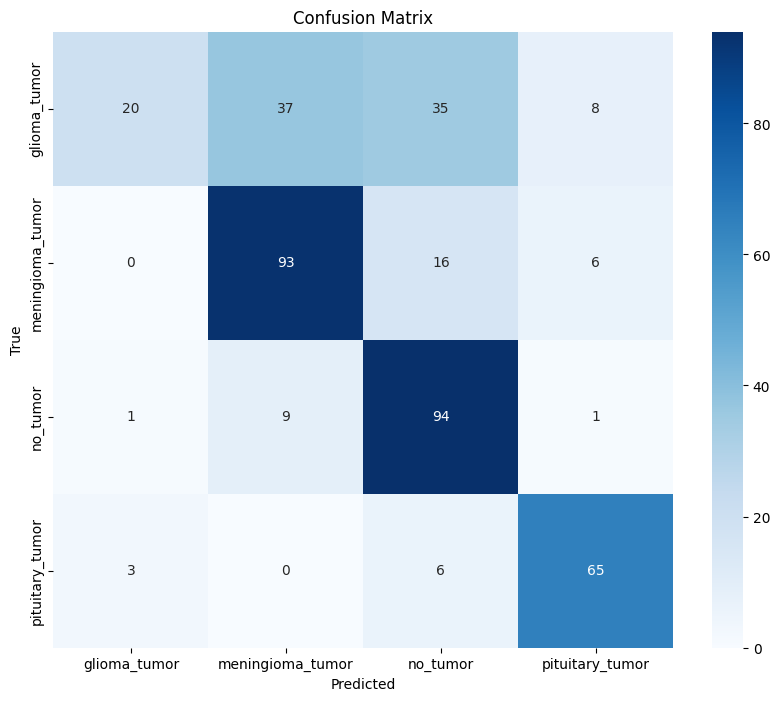

                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.20      0.32       100
meningioma_tumor       0.67      0.81      0.73       115
        no_tumor       0.62      0.90      0.73       105
 pituitary_tumor       0.81      0.88      0.84        74

        accuracy                           0.69       394
       macro avg       0.73      0.70      0.66       394
    weighted avg       0.73      0.69      0.65       394



In [23]:
# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'], yticklabels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Afficher le rapport de classification
print(classification_report(ytest_classes, ypred_classes, target_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

In [1]:
from sklearn.metrics import accuracy_score
# Calculer la précision globale
accuracy = accuracy_score(ytest_classes, ypred_classes)
print(f'Global accuracy: {accuracy:.2f}')

NameError: name 'ytest_classes' is not defined

In [ ]:
#  make predictions on the testing data
preds = model.predict(xtest, batch_size=32, verbose=1)

# score cross-entropy loss
score = log_loss(ytest, preds)
score

In [ ]:

ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

In [ ]:
import matplotlib.pyplot as plt
label=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

In [ ]:
label=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

## Avec 10 epoches on a 50% d'accuarcy contre 71% avec 30 epoches